In [266]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import initializers


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [277]:
#load the data
data = pd.read_csv('outputs/density-data-all-100-stdev', sep=" ", header=None)
data.head()
data.columns = ['rho', 'potential', 'temp', 'stdev_pe', 'stdev_temp']
x = data.drop(['potential', 'temp'], axis=1)
y = data.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)

#split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
# train, test = train_test_split(data, test_size=0.2)

In [307]:
#splitting into k-folds
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)


In [279]:
#shuffle training data
# train_data = shuffle(train)

#separating output from x
# x_train = train_data.drop(['potential', 'temp'], axis=1)
# y_train = train_data.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)

# x_test = test.drop(['potential', 'temp'], axis=1)
# y_test = test.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)

#Separating error bars from x
error_bars_train = x_train.drop(['rho'], axis=1)
x_train = x_train.rho
error_bars_test = x_test.drop(['rho'], axis=1)
x_test = x_test.rho

# print("\n test data:", x_test[0:50], "\n", y_test[0:50])


In [280]:
#Normalization
x_train_reshape = x_train.values.reshape((-1,1))
x_test_reshape = x_test.values.reshape((-1,1))

y_train_reshape = y_train.values.reshape((-1,2))
y_test_reshape = y_test.values.reshape((-1,2))

# print(y_train_reshape)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(x_train_reshape)
xtrain_scale=scaler_x.transform(x_train_reshape)
scaler_x.fit(x_test_reshape)
xtest_scale=scaler_x.transform(x_test_reshape)
scaler_y.fit(y_train_reshape)
ytrain_scale=scaler_y.transform(y_train_reshape)
scaler_y.fit(y_test_reshape)
ytest_scale=scaler_y.transform(y_test_reshape)
# print(xtrain_scale)
# print(ytrain_scale)

In [281]:
# Merge inputs and targets for k-fold
# inputs = np.concatenate((xtrain_scale, xtest_scale), axis=0)
# targets = np.concatenate((ytrain_scale, ytest_scale), axis=0)
# print(inputs.shape)
# print(targets.shape)

In [282]:
# def custom_accuracy (y_actual, y_predicted):
#   # predictions_transformed = scaler_y.inverse_transform(y_predicted)
#   lower_limit = y_actual - error_bars_test.stdev_pe
#   upper_limit = y_actual + error_bars_test.stdev_pe
#   hits = 0
#   filter = tf.math.logical_and(y_predicted >= lower_limit, y_predicted < upper_limit, name="and")
#   hits = tf.sum(filter)

#   return hits/169
# print("Accuracy:",acc*100, "% hits:", hits, " ", i)

In [308]:
#define the model
model = keras.Sequential()
model.add(Dense(1, input_dim=1, kernel_initializer= tf.keras.initializers.Ones(), activation='relu', name='input_layer'))
model.add(Dense(5, activation='relu', name="hidden_layer"))
model.add(Dense(2, activation='linear', name="output_layer"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.summary()
# 'random_uniform'


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 2         
_________________________________________________________________
hidden_layer (Dense)         (None, 5)                 10        
_________________________________________________________________
output_layer (Dense)         (None, 2)                 12        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [309]:
# new_model = keras.models.load_model("model_5neurons_0.001LR_600epoch_5batch")
# predictions = new_model.predict(xtest_scale)

In [310]:
# model.save("/content/drive/MyDrive/Colab Notebooks/model_5neurons_0.001LR_600epoch_5batch") #"/content/drive/MyDrive/Colab Notebooks/mymodel")
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoints/my_checkpoint')

In [311]:
#training through each fold
fold_no = 1
cvscores = []
for train, validate in kfold.split(xtrain_scale, ytrain_scale):
    print("\n Fold:", fold_no)
    fold_no+=1
    #compile the model
    model.compile(loss='mse', optimizer=opt, metrics=['mae', 'accuracy'])
    history=model.fit(xtrain_scale[train], ytrain_scale[train], epochs=100, batch_size=1, verbose=0)
    # evaluate the model
    scores = model.evaluate(xtrain_scale[validate], ytrain_scale[validate], verbose=0)
    print("%s: %.2f%%",(model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



 Fold: 1
%s: %.2f%% ('mean_absolute_error', 0.042252336)

 Fold: 2
%s: %.2f%% ('mean_absolute_error', 0.03848268)

 Fold: 3
%s: %.2f%% ('mean_absolute_error', 0.037148878)

 Fold: 4
%s: %.2f%% ('mean_absolute_error', 0.02721316)

 Fold: 5
%s: %.2f%% ('mean_absolute_error', 0.012750795)



 cvscores: [0.038653262, 0.03540266, 0.03781165, 0.033957627, 0.034889948, 0.038343936, 0.03668408]


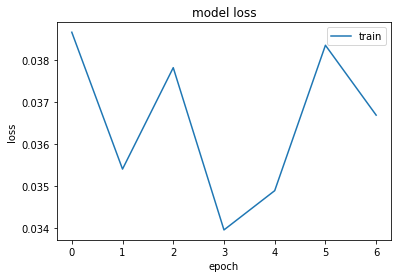

In [296]:

# print(history.history.keys())
# print(history.history.get('acc')[-1])
print("\n cvscores:", cvscores)
plt.plot(cvscores)
plt.title('model loss')
# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [297]:
predictions = model.predict(xtest_scale)
predictions_transformed = scaler_y.inverse_transform(predictions)
# predictions_transformed2 = scaler_y.inverse_transform([predictions[50:100]])
# predictions_transformed3 = scaler_y.inverse_transform([predictions[100:]])
predicted_data = pd.DataFrame(predictions_transformed)
predicted_data.columns = ['pe', 'temp']
# print(y_test)
#calculating accuracy
hits = 0
i = 0
print(y_test.shape)
for index, row in y_test.iterrows():
  lower_limit = row['potential']-error_bars_test.stdev_pe[index]
  upper_limit = row['potential']+error_bars_test.stdev_pe[index]
  #print("\n upper limit:",upper_limit," lower limit:",lower_limit," prediction:",predicted_data.pe[i])
  if predicted_data.pe[i] > lower_limit and predicted_data.pe[i] < upper_limit:
    # print(" hit")
    hits += 1
  print(x_test[index],",", y_test.potential[index],",",predicted_data.pe[i],",",error_bars_test.stdev_pe[index])
  i+=1

acc = hits/(i)
print("Success Rate:",acc*100, "% hits:", hits, " ", i)

(169, 2)
0.318 , -3.565 , -3.542664 , 0.04
0.48 , -3.6460000000000004 , -3.6195912 , 0.036000000000000004
0.35200000000000004 , -3.5839999999999996 , -3.5588095 , 0.045
0.71 , -4.145 , -4.1581473 , 0.032
0.541 , -3.677 , -3.6485577 , 0.038
0.718 , -4.178 , -4.1906724 , 0.032
0.24100000000000002 , -3.5039999999999996 , -3.5271146 , 0.066
0.28300000000000003 , -3.535 , -3.5271146 , 0.059000000000000004
0.135 , -3.471 , -3.5271146 , 0.052000000000000005
0.92 , -4.985 , -4.9394054 , 0.044000000000000004
0.9229999999999999 , -4.996 , -4.9501777 , 0.042
0.927 , -5.01 , -4.964541 , 0.042
0.863 , -4.744 , -4.734731 , 0.044000000000000004
0.789 , -4.462 , -4.469013 , 0.04
0.28 , -3.534 , -3.5271146 , 0.053
0.831 , -4.62 , -4.619826 , 0.042
0.27899999999999997 , -3.535 , -3.5271146 , 0.053
0.9470000000000001 , -5.07 , -5.0363564 , 0.040999999999999995
0.767 , -4.373 , -4.389889 , 0.04
0.47600000000000003 , -3.6319999999999997 , -3.6176918 , 0.037000000000000005
0.7659999999999999 , -4.368 , -4.3

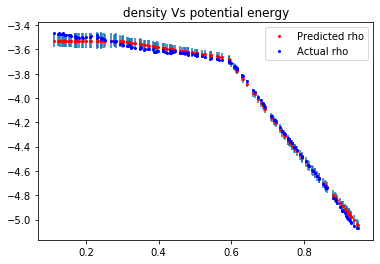

0    -3.542664
1    -3.619591
2    -3.558810
3    -4.158147
4    -3.648558
5    -4.190672
6    -3.527115
7    -3.527115
8    -3.527115
9    -4.939405
10   -4.950178
11   -4.964541
12   -4.734731
13   -4.469013
14   -3.527115
15   -4.619826
16   -3.527115
17   -5.036356
18   -4.389889
19   -3.617692
20   -4.385823
21   -3.690598
22   -4.040244
23   -4.978904
24   -4.526465
25   -3.527115
26   -3.610094
27   -4.494149
28   -3.587776
29   -4.910679
30   -4.198803
31   -3.682467
32   -3.558334
33   -4.957359
34   -3.527115
35   -4.641371
36   -4.300445
37   -4.659325
38   -3.527115
39   -3.564033
40   -4.345167
41   -3.527115
42   -3.775977
43   -3.615793
44   -4.946587
45   -3.527115
46   -3.563083
47   -3.599647
48   -3.638111
49   -3.527115
Name: pe, dtype: float32
209    0.040
371    0.036
243    0.045
601    0.032
432    0.038
609    0.032
132    0.066
174    0.059
26     0.052
811    0.044
814    0.042
818    0.042
754    0.044
680    0.040
171    0.053
722    0.042
170    0.053
838 

In [298]:
plt.plot(x_test,predicted_data.pe,"ro", markersize=2)
plt.plot(x_test,y_test.potential,"bo", markersize=2)
plt.errorbar(x_test, predicted_data.pe, yerr =error_bars_test.stdev_pe, fmt=" ")
plt.legend(['Predicted rho','Actual rho'], loc='upper right')
plt.title('density Vs potential energy')
plt.show()

print(predicted_data.pe[0:50])
print(error_bars_test.stdev_pe[0:50])